In [1]:
from pyspark import SparkContext
from pyspark.sql.session import SparkSession

sc = SparkContext(appName = 'charn-bigquery-demo')
spark = SparkSession(sc.getOrCreate())

In [2]:
from google.cloud import bigquery

client = bigquery.Client()

## To get datasets of a project ==> the dataset must be specefied beforehand

class BqManager:
    def __init__(self,project_id):
        self.project_id = project_id
        self.client = bigquery.Client(self.project_id)

    # then explore the datasets of the project
    def get_datasets(self):
        datasets = {}
        datasets_iter = list(self.client.list_datasets())
        for dataset in datasets_iter:
            dataset_id = dataset.dataset_id
            datasets[dataset_id] = dataset
        return datasets
    
    def get_actual_dataset(self,dataset_id):
        dataset = self.client.get_dataset(dataset_id)
        return dataset
# explore tables/views within a dataset
    def get_tables(self, dataset_id):
        self.dataset_id = dataset_id
        tables = {}
        table_list = list(self.client.list_tables(dataset_id))
        for table in table_list:
            table_id = table.table_id
            tables[table_id] = table
        return tables

# get automatically the schema of the table
    def get_schema(self,table_id):
        table_str = f'{self.project_id}.{self.dataset_id}.{table_id}'
        table = self.client.get_table(table_str)
        schema = table.schema
        key_value_schema = {}
        for item in schema:
            key_value_schema[item.name] = item.field_type
        return key_value_schema



/home/kevrodz/.pyenv/versions/myenv/lib/python3.7/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/home/kevrodz/.pyenv/versions/myenv/lib/python3.7/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see http

In [3]:
import json

def replaceMultiple(mainString, toBeReplaces, newString):
    # Iterate over the strings to be replaced
    for elem in toBeReplaces :
        # Check if string is in the main string
        if elem in mainString :
            # Replace the string
            mainString = mainString.replace(elem, newString)
    return mainString

def extract_num(feature_name):
    number = feature_name.split(' ')
    return int(number[1])

def extract_sym_val(feature_name):
    sym_val = feature_name.split(' ')
    if sym_val[2] == 'not' or sym_val[3] == 'in':
        # ['feature', '1', 'not', 'in', '{1.0}']
        #sym = sym_val[2] + ' ' + sym_val[3]
        sym = '!='
        val = replaceMultiple(sym_val[4],['{','}'], '')
    else:
        # ['feature', '1', 'in', '{1.0}']
        if sym_val[2] == 'in':
            sym = '=='
        else:
            sym = sym_val[2]
        val = replaceMultiple(sym_val[3],['{','}'], '')
    return sym, val

def parse(lines, dataset):
    block = []
    while lines:
            if lines[0].startswith('If'):
                bl = ' '.join(lines.pop(0).split()[1:]).replace('(', '').replace(')', '')
                sym, val = extract_sym_val(bl)
                block.append({'name':dataset.columns[extract_num(bl)] + ' ' + sym + ' ' + val, 'children':parse(lines, dataset)})
                if lines[0].startswith('Else'):
                    be = ' '.join(lines.pop(0).split()[1:]).replace('(', '').replace(')', '')
                    sym, val = extract_sym_val(be)
                    block.append({'name':dataset.columns[extract_num(be)] + ' ' + sym + ' ' + val, 'children':parse(lines, dataset)}) 
            elif not lines[0].startswith(('If','Else')):
                block2 = lines.pop(0)
                block.append({'name':block2}) # Add the predict value   
            else:
                break
                
    return block

# Convert Tree to JSON
def tree_json(tree, dataset):
    data = []
    for line in tree.splitlines() : 
        if line.strip():
            line = line.strip()
            data.append(line)
        else : break
        if not line : break
    res = []
    res.append({'name':'Root', 'children':parse(data[1:], dataset)})
    with open('structure.json', 'w') as outfile:
        json.dump(res[0], outfile)
    print('Conversion Success !')

In [4]:
bqManager = BqManager('bright-bda')
dbtgran_ds = bqManager.get_datasets()
dbtgran_ds

/home/kevrodz/.pyenv/versions/myenv/lib/python3.7/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


{'5963decd5f69f9364f7a1afa': <google.cloud.bigquery.dataset.DatasetListItem at 0x7f5c90734c90>,
 'adquire': <google.cloud.bigquery.dataset.DatasetListItem at 0x7f5c54728f10>,
 'appsflyer_data': <google.cloud.bigquery.dataset.DatasetListItem at 0x7f5c546f50d0>,
 'bdafiles': <google.cloud.bigquery.dataset.DatasetListItem at 0x7f5c52993890>,
 'coreOS_TEST': <google.cloud.bigquery.dataset.DatasetListItem at 0x7f5c52993950>,
 'development': <google.cloud.bigquery.dataset.DatasetListItem at 0x7f5c52993b90>,
 'natura': <google.cloud.bigquery.dataset.DatasetListItem at 0x7f5c54733090>,
 'pixel_mb_raw': <google.cloud.bigquery.dataset.DatasetListItem at 0x7f5c54733210>,
 'pixel_raw': <google.cloud.bigquery.dataset.DatasetListItem at 0x7f5c75c54350>,
 'pixels_data': <google.cloud.bigquery.dataset.DatasetListItem at 0x7f5c75c54050>,
 'production': <google.cloud.bigquery.dataset.DatasetListItem at 0x7f5c90732790>,
 'telefonica_migracion_clustering': <google.cloud.bigquery.dataset.DatasetListItem at

In [5]:
bqManager.get_tables('bdafiles')
bqManager.get_schema('churn_example')

{'Account_Length': 'INTEGER',
 'Vmail_Message': 'INTEGER',
 'Day_Mins': 'FLOAT',
 'Eve_Mins': 'FLOAT',
 'Night_Mins': 'FLOAT',
 'Intl_Mins': 'FLOAT',
 'CustServ_Calls': 'INTEGER',
 'Churn': 'BOOLEAN',
 'Intl_Plan': 'BOOLEAN',
 'Vmail_Plan': 'BOOLEAN',
 'Day_Calls': 'INTEGER',
 'Day_Charge': 'FLOAT',
 'Eve_Calls': 'INTEGER',
 'Eve_Charge': 'FLOAT',
 'Night_Calls': 'INTEGER',
 'Night_Charge': 'FLOAT',
 'Intl_Calls': 'INTEGER',
 'Intl_Charge': 'FLOAT',
 'State': 'STRING',
 'Area_Code': 'INTEGER',
 'Phone': 'STRING'}

In [6]:
# from google.cloud import bigquery
# client = bigquery.Client()

query = (
    'SELECT COUNT(CASE WHEN Churn = false THEN Churn END) AS COUNT_FALSE_CHURN, COUNT(CASE WHEN Churn = true THEN Churn END) AS COUNT_TRUE_CHURN  FROM `bright-bda.bdafiles.churn_example`'
)
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

for row in query_job:  # API request - fetches results
    # Row values can be accessed by field name or index
    #assert row[0] == row.name == row["name"]
    print(row)

Row((2850, 483), {'COUNT_FALSE_CHURN': 0, 'COUNT_TRUE_CHURN': 1})


In [7]:
results = query_job.result()  # Waits for job to complete.
for row in results:
    print("Count false churn: {}, Count true churn {}".format(row.COUNT_FALSE_CHURN, row.COUNT_TRUE_CHURN))

Count false churn: 2850, Count true churn 483


In [8]:
sql = """
    SELECT *
    FROM `bright-bda.bdafiles.churn_example`
"""
df = client.query(sql).to_dataframe()

In [9]:
df.head()

Account_Length  Vmail_Message  Day_Mins  Eve_Mins  Night_Mins  Intl_Mins  \
0              70              0     232.1     292.3       201.2        0.0   
1             165              0     242.9     209.8       228.4        0.0   
2             106              0     114.4      78.3       232.7        0.0   
3              62              0     281.0     160.6        77.9        0.0   
4              70              0     222.8     215.9       223.5        0.0   

   CustServ_Calls  Churn  Intl_Plan  Vmail_Plan  ...  Day_Charge  Eve_Calls  \
0               3  False      False       False  ...       39.46        112   
1               1  False      False       False  ...       41.29         65   
2               2  False      False       False  ...       19.45        101   
3               1  False      False       False  ...       47.77        108   
4               1  False      False       False  ...       37.88        113   

   Eve_Charge  Night_Calls  Night_Charge  Intl_Calls  Intl_Charge  State  \
0       24.85          112          9.05           0          0.0     KS   
1       17.83          126         10.28           0          0.0     VT   
2        6.66           78         10.47           0          0.0     MO   
3       13.65           74          3.51           0          0.0     WI   
4       18.35          122         10.06           0          0.0     KS   

  Area_Code     Phone  
0       408  411-4582  
1       510  345-1998  
2       415  340-9910  
3       415  383-6373  
4       415  369-9465  

[5 rows x 21 columns]

In [10]:
# https://dataplatform.cloud.ibm.com/exchange/public/entry/view/5ad1c820f57809ddec9a040e37b2bd55
from pyspark.sql import SQLContext

sqlContext = SQLContext(sc)

In [11]:
spark_df = sqlContext.createDataFrame(df)  # Convert to a Spark DataFrame

In [12]:
spark_df.show(2)

+--------------+-------------+--------+--------+----------+---------+--------------+-----+---------+----------+---------+----------+---------+----------+-----------+------------+----------+-----------+-----+---------+--------+
|Account_Length|Vmail_Message|Day_Mins|Eve_Mins|Night_Mins|Intl_Mins|CustServ_Calls|Churn|Intl_Plan|Vmail_Plan|Day_Calls|Day_Charge|Eve_Calls|Eve_Charge|Night_Calls|Night_Charge|Intl_Calls|Intl_Charge|State|Area_Code|   Phone|
+--------------+-------------+--------+--------+----------+---------+--------------+-----+---------+----------+---------+----------+---------+----------+-----------+------------+----------+-----------+-----+---------+--------+
|            70|            0|   232.1|   292.3|     201.2|      0.0|             3|false|    false|     false|      122|     39.46|      112|     24.85|        112|        9.05|         0|        0.0|   KS|      408|411-4582|
|           165|            0|   242.9|   209.8|     228.4|      0.0|             1|false|  

In [13]:
spark_df.registerTempTable("churn_example_table")  # Register the Spark DataFrame as a table

In [14]:
print(sqlContext.sql("SELECT COUNT(CASE WHEN Churn = false THEN Churn END) AS COUNT_FALSE_CHURN,\
                     COUNT(CASE WHEN Churn = true THEN Churn END) AS COUNT_TRUE_CHURN \
                     FROM churn_example_table").collect())  # Run an SQL statement

[Row(COUNT_FALSE_CHURN=2850, COUNT_TRUE_CHURN=483)]


In [15]:
import warnings
import pandas as pd
import seaborn as sns
warnings.filterwarnings('ignore')
# https://mapr.com/blog/churn-prediction-pyspark-using-mllib-and-ml-packages/

In [16]:
spark_df.cache()
spark_df.printSchema()

root
 |-- Account_Length: long (nullable = true)
 |-- Vmail_Message: long (nullable = true)
 |-- Day_Mins: double (nullable = true)
 |-- Eve_Mins: double (nullable = true)
 |-- Night_Mins: double (nullable = true)
 |-- Intl_Mins: double (nullable = true)
 |-- CustServ_Calls: long (nullable = true)
 |-- Churn: boolean (nullable = true)
 |-- Intl_Plan: boolean (nullable = true)
 |-- Vmail_Plan: boolean (nullable = true)
 |-- Day_Calls: long (nullable = true)
 |-- Day_Charge: double (nullable = true)
 |-- Eve_Calls: long (nullable = true)
 |-- Eve_Charge: double (nullable = true)
 |-- Night_Calls: long (nullable = true)
 |-- Night_Charge: double (nullable = true)
 |-- Intl_Calls: long (nullable = true)
 |-- Intl_Charge: double (nullable = true)
 |-- State: string (nullable = true)
 |-- Area_Code: long (nullable = true)
 |-- Phone: string (nullable = true)



In [17]:
pd.DataFrame(spark_df.take(5), columns=spark_df.columns).transpose()

0         1         2         3         4
Account_Length        70       165       106        62        70
Vmail_Message          0         0         0         0         0
Day_Mins           232.1     242.9     114.4       281     222.8
Eve_Mins           292.3     209.8      78.3     160.6     215.9
Night_Mins         201.2     228.4     232.7      77.9     223.5
Intl_Mins              0         0         0         0         0
CustServ_Calls         3         1         2         1         1
Churn              False     False     False     False     False
Intl_Plan          False     False     False     False     False
Vmail_Plan         False     False     False     False     False
Day_Calls            122       126       104        66       114
Day_Charge         39.46     41.29     19.45     47.77     37.88
Eve_Calls            112        65       101       108       113
Eve_Charge         24.85     17.83      6.66     13.65     18.35
Night_Calls          112       126        78        74       122
Night_Charge        9.05     10.28     10.47      3.51     10.06
Intl_Calls             0         0         0         0         0
Intl_Charge            0         0         0         0         0
State                 KS        VT        MO        WI        KS
Area_Code            408       510       415       415       415
Phone           411-4582  345-1998  340-9910  383-6373  369-9465

In [18]:
spark_df.describe().toPandas().transpose()

0                   1                   2         3  \
summary         count                mean              stddev       min   
Account_Length   3333  101.06480648064806   39.82210592859561         1   
Vmail_Message    3333   8.099009900990099  13.688365372038591         0   
Day_Mins         3333  179.77509750975102   54.46738920237138       0.0   
Eve_Mins         3333   200.9803480348034     50.713844425812       0.0   
Night_Mins       3333   200.8720372037203   50.57384701365836      23.2   
Intl_Mins        3333   10.23729372937293  2.7918395484084155       0.0   
CustServ_Calls   3333  1.5628562856285628  1.3154910448664767         0   
Day_Calls        3333  100.43564356435644  20.069084207300897         0   
Day_Charge       3333  30.562307230723075     9.2594345539305       0.0   
Eve_Calls        3333  100.11431143114311    19.9226252939431         0   
Eve_Charge       3333  17.083540354035403   4.310667643110341       0.0   
Night_Calls      3333  100.10771077107711  19.568609346058558        33   
Night_Charge     3333   9.039324932493253  2.2758728376600286      1.04   
Intl_Calls       3333  4.4794479447944795  2.4612142705460944         0   
Intl_Charge      3333   2.764581458145813  0.7537726126630461       0.0   
State            3333                None                None        AK   
Area_Code        3333  437.18241824182417  42.371290485606615       408   
Phone            3333                None                None  327-1058   

                       4  
summary              max  
Account_Length       243  
Vmail_Message         51  
Day_Mins           350.8  
Eve_Mins           363.7  
Night_Mins         395.0  
Intl_Mins           20.0  
CustServ_Calls         9  
Day_Calls            165  
Day_Charge         59.64  
Eve_Calls            170  
Eve_Charge         30.91  
Night_Calls          175  
Night_Charge       17.77  
Intl_Calls            20  
Intl_Charge          5.4  
State                 WY  
Area_Code            510  
Phone           422-9964

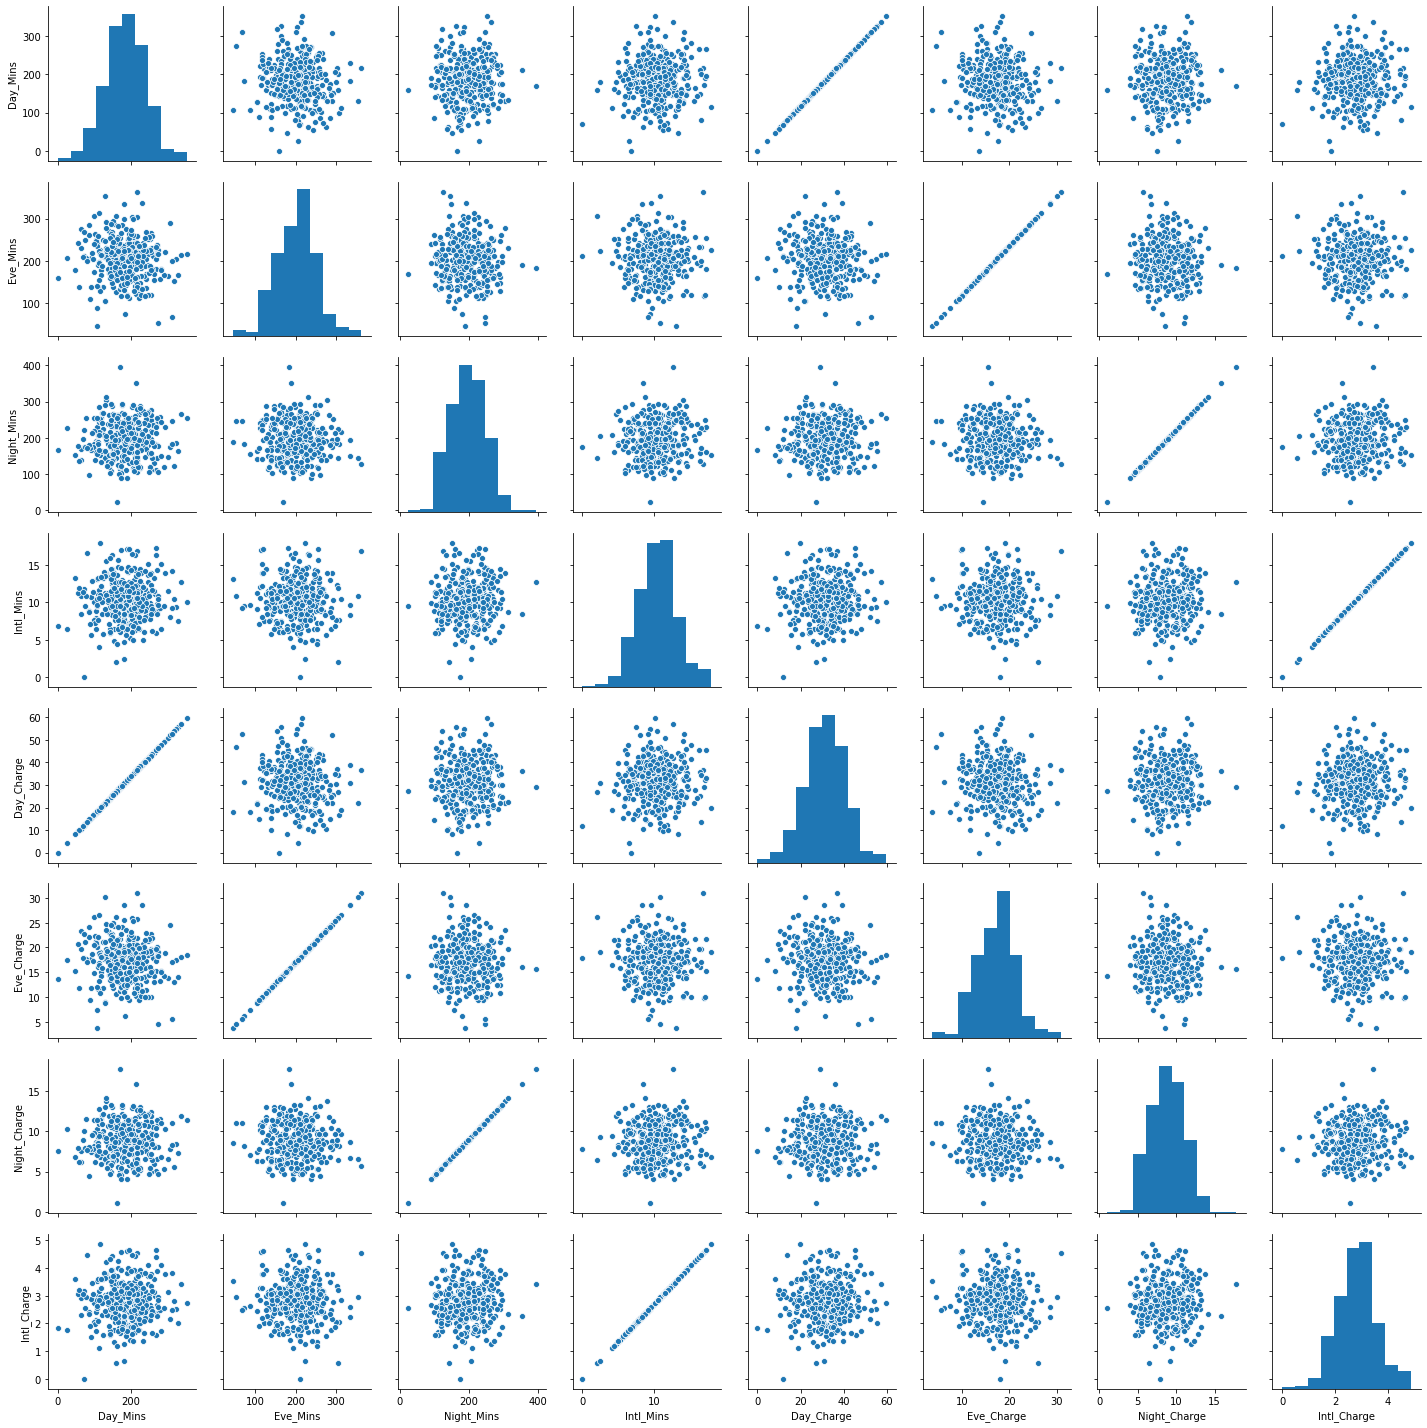

In [19]:
numeric_features = [t[0] for t in spark_df.dtypes if t[1] == 'int' or t[1] == 'double' or t[1] == 'long']

sampled_data = spark_df.select(numeric_features).sample(False, 0.10).toPandas()

sns.pairplot(sampled_data)


In [20]:
spark_df2 = spark_df.drop('State').drop('Area_Code').drop('Phone').drop('Day_Charge').drop('Eve_Charge').drop('Night_Charge').drop('Intl_Charge').cache()
spark_df2.show(2)

+--------------+-------------+--------+--------+----------+---------+--------------+-----+---------+----------+---------+---------+-----------+----------+
|Account_Length|Vmail_Message|Day_Mins|Eve_Mins|Night_Mins|Intl_Mins|CustServ_Calls|Churn|Intl_Plan|Vmail_Plan|Day_Calls|Eve_Calls|Night_Calls|Intl_Calls|
+--------------+-------------+--------+--------+----------+---------+--------------+-----+---------+----------+---------+---------+-----------+----------+
|            70|            0|   232.1|   292.3|     201.2|      0.0|             3|false|    false|     false|      122|      112|        112|         0|
|           165|            0|   242.9|   209.8|     228.4|      0.0|             1|false|    false|     false|      126|       65|        126|         0|
+--------------+-------------+--------+--------+----------+---------+--------------+-----+---------+----------+---------+---------+-----------+----------+
only showing top 2 rows



In [21]:
'''
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import UserDefinedFunction

binary_map = {'Yes':1.0, 'No':0.0, 'True':1.0, 'False':0.0}
toNum = UserDefinedFunction(lambda k: binary_map[k], DoubleType())

spark_df = spark_df.drop('State').drop('Area_Code').drop('Phone') \
    .drop('Day_Charge').drop('Eve_Charge') \
    .drop('Night_Charge').drop('Intl_Charge') \
    .withColumn('Churn', toNum(spark_df['Churn'])) \
    .withColumn('Intl_Plan', toNum(spark_df['Intl_Plan'])) \
    .withColumn('Vmail_Plan', toNum(spark_df['Vmail_Plan'])).cache()
'''

"\nfrom pyspark.sql.types import DoubleType\nfrom pyspark.sql.functions import UserDefinedFunction\n\nbinary_map = {'Yes':1.0, 'No':0.0, 'True':1.0, 'False':0.0}\ntoNum = UserDefinedFunction(lambda k: binary_map[k], DoubleType())\n\nspark_df = spark_df.drop('State').drop('Area_Code').drop('Phone')     .drop('Day_Charge').drop('Eve_Charge')     .drop('Night_Charge').drop('Intl_Charge')     .withColumn('Churn', toNum(spark_df['Churn']))     .withColumn('Intl_Plan', toNum(spark_df['Intl_Plan']))     .withColumn('Vmail_Plan', toNum(spark_df['Vmail_Plan'])).cache()\n"

In [22]:
spark_df2 = spark_df2.select('Account_Length', 'Intl_Plan', 'Vmail_Plan',
                             'Vmail_Message', 'Day_Mins', 'Day_Calls',
                             'Eve_Mins', 'Eve_Calls', 'Night_Mins',
                             'Night_Calls', 'Intl_Mins', 'Intl_Calls',
                             'CustServ_Calls', 'Churn')
spark_df2.cache()
spark_df2.printSchema()

root
 |-- Account_Length: long (nullable = true)
 |-- Intl_Plan: boolean (nullable = true)
 |-- Vmail_Plan: boolean (nullable = true)
 |-- Vmail_Message: long (nullable = true)
 |-- Day_Mins: double (nullable = true)
 |-- Day_Calls: long (nullable = true)
 |-- Eve_Mins: double (nullable = true)
 |-- Eve_Calls: long (nullable = true)
 |-- Night_Mins: double (nullable = true)
 |-- Night_Calls: long (nullable = true)
 |-- Intl_Mins: double (nullable = true)
 |-- Intl_Calls: long (nullable = true)
 |-- CustServ_Calls: long (nullable = true)
 |-- Churn: boolean (nullable = true)



In [23]:
pd.DataFrame(spark_df2.take(5), columns=spark_df2.columns).transpose()


0      1      2      3      4
Account_Length     70    165    106     62     70
Intl_Plan       False  False  False  False  False
Vmail_Plan      False  False  False  False  False
Vmail_Message       0      0      0      0      0
Day_Mins        232.1  242.9  114.4    281  222.8
Day_Calls         122    126    104     66    114
Eve_Mins        292.3  209.8   78.3  160.6  215.9
Eve_Calls         112     65    101    108    113
Night_Mins      201.2  228.4  232.7   77.9  223.5
Night_Calls       112    126     78     74    122
Intl_Mins           0      0      0      0      0
Intl_Calls          0      0      0      0      0
CustServ_Calls      3      1      2      1      1
Churn           False  False  False  False  False

In [24]:
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.tree import DecisionTree

def labelData(data):
    # label: row[end], features: row[0:end-1]
    return data.rdd.map(lambda row: LabeledPoint(row[-1], row[:-1]))



training_data, testing_data = labelData(spark_df2).randomSplit([0.7, 0.3])

model = DecisionTree.trainClassifier(training_data, numClasses=2, #maxDepth=2,
                                     categoricalFeaturesInfo={1:2, 2:2},
                                     impurity='gini', maxBins=32)
print(model.toDebugString())

DecisionTreeModel classifier of depth 5 with 49 nodes
  If (feature 4 <= 265.0)
   If (feature 12 <= 3.5)
    If (feature 1 in {1.0})
     If (feature 11 <= 2.5)
      Predict: 1.0
     Else (feature 11 > 2.5)
      If (feature 10 <= 13.25)
       Predict: 0.0
      Else (feature 10 > 13.25)
       Predict: 1.0
    Else (feature 1 not in {1.0})
     If (feature 4 <= 221.75)
      Predict: 0.0
     Else (feature 4 > 221.75)
      If (feature 6 <= 240.64999999999998)
       Predict: 0.0
      Else (feature 6 > 240.64999999999998)
       Predict: 1.0
   Else (feature 12 > 3.5)
    If (feature 4 <= 161.14999999999998)
     If (feature 6 <= 230.05)
      If (feature 7 <= 128.5)
       Predict: 1.0
      Else (feature 7 > 128.5)
       Predict: 0.0
     Else (feature 6 > 230.05)
      If (feature 4 <= 126.85)
       Predict: 1.0
      Else (feature 4 > 126.85)
       Predict: 0.0
    Else (feature 4 > 161.14999999999998)
     If (feature 6 <= 136.25)
      If (feature 7 <= 125.5)
       Pred

In [25]:
tree_to_json = model.toDebugString()
tree_json(tree_to_json, spark_df2)

Conversion Success !


In [26]:
from pyspark.mllib.evaluation import MulticlassMetrics

def getPredictionsLabels(model, test_data):
    predictions = model.predict(test_data.map(lambda r: r.features))
    return predictions.zip(test_data.map(lambda r: r.label))

def printMetrics(predictions_and_labels):
    metrics = MulticlassMetrics(predictions_and_labels)
    print('Precision of True: ', metrics.precision(1))
    print('Precision of False:', metrics.precision(0))
    print('Recall of True:    ', metrics.recall(1))
    print('Recall of False:   ', metrics.recall(0))
    print('F-1 Score:         ', metrics.fMeasure())
    print('Confusion Matrix\n', metrics.confusionMatrix().toArray())

predictions_and_labels = getPredictionsLabels(model, testing_data)

printMetrics(predictions_and_labels)

Precision of True:  0.8220338983050848
Precision of False: 0.9318435754189944
Recall of True:     0.6139240506329114
Recall of False:    0.9754385964912281
F-1 Score:          0.9190523198420533
Confusion Matrix
 [[834.  21.]
 [ 61.  97.]]


In [27]:
root = model.call("topNode")
root.impurity() # gives the impurity of the root no

0.24092412306777639

In [28]:
dir(root)

['apply',
 'deepCopy',
 'emptyNode',
 'equals',
 'getClass',
 'getNode',
 'hashCode',
 'id',
 'impurity',
 'impurity_$eq',
 'indexToLevel',
 'initializeLogIfNecessary',
 'initializeLogIfNecessary$default$2',
 'isLeaf',
 'isLeaf_$eq',
 'isLeftChild',
 'isTraceEnabled',
 'leftChildIndex',
 'leftNode',
 'leftNode_$eq',
 'log',
 'logDebug',
 'logError',
 'logInfo',
 'logName',
 'logTrace',
 'logWarning',
 'maxNodesInLevel',
 'notify',
 'notifyAll',
 'numDescendants',
 'org$apache$spark$internal$Logging$$log_',
 'org$apache$spark$internal$Logging$$log__$eq',
 'parentIndex',
 'predict',
 'predict_$eq',
 'rightChildIndex',
 'rightNode',
 'rightNode_$eq',
 'split',
 'split_$eq',
 'startIndexInLevel',
 'stats',
 'stats_$eq',
 'subtreeDepth',
 'subtreeIterator',
 'subtreeToString',
 'subtreeToString$default$1',
 'toString',
 'wait']

In [29]:
print(f'root \nleft: {root.leftNode().get().impurity()}, right: {root.rightNode().get().impurity()}')

root 
left: 0.1941840665873959, right: 0.47714625445897746


In [30]:
print(f'left \nleft: {root.leftNode().get().leftNode().get().impurity()}, right: {root.leftNode().get().rightNode().get().impurity()}')
print(f'right \nleft: {root.rightNode().get().leftNode().get().impurity()}, right: {root.rightNode().get().rightNode().get().impurity()}')

left 
left: 0.1368886340938509, right: 0.49947970863683666
right 
left: 0.20244897959183678, right: 0.3609917355371901


In [31]:
print(root.leftNode().get().stats())

Some(gain = 0.02628764404986899, impurity = 0.1941840665873959, left impurity = 0.1368886340938509, right impurity = 0.49947970863683666)


In [32]:
def _get_root_node(tree):
    return tree.call("topNode")

def get_impurities(tree):
    def recur(node):
        print(f'node: {node}')
        if node.numDescendants() == 0:
            return []
        #ni = node.impurity()
        return (
            recur(node.leftNode().get().impurity()) + recur(node.rightNode())
        )
    return recur(_get_root_node(tree))



In [33]:
#get_impurities(model)

In [34]:
root2 = model.call("topNode")

In [35]:
root2.leftNode().get().impurity()

0.1941840665873959

In [36]:
root2.numDescendants()

48

In [37]:
dir(model.call("topNode"))

['apply',
 'deepCopy',
 'emptyNode',
 'equals',
 'getClass',
 'getNode',
 'hashCode',
 'id',
 'impurity',
 'impurity_$eq',
 'indexToLevel',
 'initializeLogIfNecessary',
 'initializeLogIfNecessary$default$2',
 'isLeaf',
 'isLeaf_$eq',
 'isLeftChild',
 'isTraceEnabled',
 'leftChildIndex',
 'leftNode',
 'leftNode_$eq',
 'log',
 'logDebug',
 'logError',
 'logInfo',
 'logName',
 'logTrace',
 'logWarning',
 'maxNodesInLevel',
 'notify',
 'notifyAll',
 'numDescendants',
 'org$apache$spark$internal$Logging$$log_',
 'org$apache$spark$internal$Logging$$log__$eq',
 'parentIndex',
 'predict',
 'predict_$eq',
 'rightChildIndex',
 'rightNode',
 'rightNode_$eq',
 'split',
 'split_$eq',
 'startIndexInLevel',
 'stats',
 'stats_$eq',
 'subtreeDepth',
 'subtreeIterator',
 'subtreeToString',
 'subtreeToString$default$1',
 'toString',
 'wait']

In [38]:
model.call("topNode").toString()

'id = 1, isLeaf = false, predict = 0.0 (prob = 0.8599137931034483), impurity = 0.24092412306777639, split = Some(Feature = 4, threshold = 265.0, featureType = Continuous, categories = List()), stats = Some(gain = 0.029054919738406643, impurity = 0.24092412306777639, left impurity = 0.1941840665873959, right impurity = 0.47714625445897746)'

In [39]:
model.call("topNode").predict().prob() 

0.8599137931034483

In [40]:
#dir(root2.leftNode().get().predict().prob())
root2.leftNode().get().predict().prob()

0.8910344827586207

In [41]:
dir(root.leftNode().get())

['apply',
 'deepCopy',
 'emptyNode',
 'equals',
 'getClass',
 'getNode',
 'hashCode',
 'id',
 'impurity',
 'impurity_$eq',
 'indexToLevel',
 'initializeLogIfNecessary',
 'initializeLogIfNecessary$default$2',
 'isLeaf',
 'isLeaf_$eq',
 'isLeftChild',
 'isTraceEnabled',
 'leftChildIndex',
 'leftNode',
 'leftNode_$eq',
 'log',
 'logDebug',
 'logError',
 'logInfo',
 'logName',
 'logTrace',
 'logWarning',
 'maxNodesInLevel',
 'notify',
 'notifyAll',
 'numDescendants',
 'org$apache$spark$internal$Logging$$log_',
 'org$apache$spark$internal$Logging$$log__$eq',
 'parentIndex',
 'predict',
 'predict_$eq',
 'rightChildIndex',
 'rightNode',
 'rightNode_$eq',
 'split',
 'split_$eq',
 'startIndexInLevel',
 'stats',
 'stats_$eq',
 'subtreeDepth',
 'subtreeIterator',
 'subtreeToString',
 'subtreeToString$default$1',
 'toString',
 'wait']

In [42]:
root.leftNode().get().leftNode().get().leftNode().get().leftNode().get().isLeaf()

True

In [43]:
root.toString()

'id = 1, isLeaf = false, predict = 0.0 (prob = 0.8599137931034483), impurity = 0.24092412306777639, split = Some(Feature = 4, threshold = 265.0, featureType = Continuous, categories = List()), stats = Some(gain = 0.029054919738406643, impurity = 0.24092412306777639, left impurity = 0.1941840665873959, right impurity = 0.47714625445897746)'

In [44]:
root.leftNode().get().toString()

'id = 2, isLeaf = false, predict = 0.0 (prob = 0.8910344827586207), impurity = 0.1941840665873959, split = Some(Feature = 12, threshold = 3.5, featureType = Continuous, categories = List()), stats = Some(gain = 0.02628764404986899, impurity = 0.1941840665873959, left impurity = 0.1368886340938509, right impurity = 0.49947970863683666)'

In [45]:
root.leftNode().get().leftNode().get().id()

4

In [151]:
import json

with open('structure.json') as json_file:
    data = json.load(json_file)

In [152]:
data

{'name': 'Root',
 'children': [{'name': 'Day_Mins <= 265.0',
   'children': [{'name': 'CustServ_Calls <= 3.5',
     'children': [{'name': 'Intl_Plan == 1.0',
       'children': [{'name': 'Intl_Calls <= 2.5',
         'children': [{'name': 'Predict: 1.0'}]},
        {'name': 'Intl_Calls > 2.5',
         'children': [{'name': 'Intl_Mins <= 13.25',
           'children': [{'name': 'Predict: 0.0'}]},
          {'name': 'Intl_Mins > 13.25',
           'children': [{'name': 'Predict: 1.0'}]}]}]},
      {'name': 'Intl_Plan != 1.0',
       'children': [{'name': 'Day_Mins <= 221.75',
         'children': [{'name': 'Predict: 0.0'}]},
        {'name': 'Day_Mins > 221.75',
         'children': [{'name': 'Eve_Mins <= 240.64999999999998',
           'children': [{'name': 'Predict: 0.0'}]},
          {'name': 'Eve_Mins > 240.64999999999998',
           'children': [{'name': 'Predict: 1.0'}]}]}]}]},
    {'name': 'CustServ_Calls > 3.5',
     'children': [{'name': 'Day_Mins <= 161.14999999999998',
     

In [48]:
def walk_json(tree, path=[]):
    try:
        for root, child in tree.items():
            yield from walk_json(child, path + [root])
    except AttributeError: # in case .items() is not possible (on leaves)
        yield path + [tree]

data_list = list(walk_json(data))

In [49]:
data_right = data['children'][1]
data_right

{'name': 'Day_Mins > 265.0',
 'children': [{'name': 'Vmail_Plan == 1.0',
   'children': [{'name': 'Intl_Plan == 0.0',
     'children': [{'name': 'Eve_Mins <= 259.1',
       'children': [{'name': 'Predict: 0.0'}]},
      {'name': 'Eve_Mins > 259.1',
       'children': [{'name': 'Account_Length <= 97.5',
         'children': [{'name': 'Predict: 0.0'}]},
        {'name': 'Account_Length > 97.5',
         'children': [{'name': 'Predict: 1.0'}]}]}]},
    {'name': 'Intl_Plan != 0.0',
     'children': [{'name': 'Account_Length <= 94.5',
       'children': [{'name': 'Day_Mins <= 279.95',
         'children': [{'name': 'Predict: 1.0'}]},
        {'name': 'Day_Mins > 279.95',
         'children': [{'name': 'Predict: 0.0'}]}]},
      {'name': 'Account_Length > 94.5',
       'children': [{'name': 'Predict: 1.0'}]}]}]},
  {'name': 'Vmail_Plan != 1.0',
   'children': [{'name': 'Eve_Mins <= 185.25',
     'children': [{'name': 'Day_Mins <= 279.95',
       'children': [{'name': 'Predict: 0.0'}]},
     

In [50]:
data_left = data['children'][0]
data_left

{'name': 'Day_Mins <= 265.0',
 'children': [{'name': 'CustServ_Calls <= 3.5',
   'children': [{'name': 'Intl_Plan == 1.0',
     'children': [{'name': 'Intl_Calls <= 2.5',
       'children': [{'name': 'Predict: 1.0'}]},
      {'name': 'Intl_Calls > 2.5',
       'children': [{'name': 'Intl_Mins <= 13.25',
         'children': [{'name': 'Predict: 0.0'}]},
        {'name': 'Intl_Mins > 13.25',
         'children': [{'name': 'Predict: 1.0'}]}]}]},
    {'name': 'Intl_Plan != 1.0',
     'children': [{'name': 'Day_Mins <= 221.75',
       'children': [{'name': 'Predict: 0.0'}]},
      {'name': 'Day_Mins > 221.75',
       'children': [{'name': 'Eve_Mins <= 240.64999999999998',
         'children': [{'name': 'Predict: 0.0'}]},
        {'name': 'Eve_Mins > 240.64999999999998',
         'children': [{'name': 'Predict: 1.0'}]}]}]}]},
  {'name': 'CustServ_Calls > 3.5',
   'children': [{'name': 'Day_Mins <= 161.14999999999998',
     'children': [{'name': 'Eve_Mins <= 230.05',
       'children': [{'nam

In [86]:
#data_dere['name']
try:
    data_right['children'][0]['children'][0]['children'][0]['children'][0]
except KeyError:
    data_right['children'][0]['children'][0]['children'][0]
    print('Error')
    

In [87]:
data_left['children'][0]['children'][0]['children'][1]['children'][0]['children'][0]

{'name': 'Predict: 0.0'}

In [89]:
data_right['name']

'Day_Mins > 265.0'

In [90]:
print(model.depth(), model.numNodes())

5 49


In [ ]:
#data['children']
#for key, lista in data['children'][0].items():
#	print(key)
#	print(lista)

In [137]:
for key, lista in data.items():
    print(f'key: {key}')
    print(f'lista: {lista}')
    if key == 'children':
        a = lista[0]
        print(type(lista))
        #iter_paths(lista)
        for k, i in lista[0].items():
            print(f'lista2: {i}')
        for k, i in lista[1].items():
            print(f'lista3: {i}')

key: name
lista: Root
key: children
lista: [{'name': 'Day_Mins <= 265.0', 'children': [{'name': 'CustServ_Calls <= 3.5', 'children': [{'name': 'Intl_Plan == 1.0', 'children': [{'name': 'Intl_Calls <= 2.5', 'children': [{'name': 'Predict: 1.0'}]}, {'name': 'Intl_Calls > 2.5', 'children': [{'name': 'Intl_Mins <= 13.25', 'children': [{'name': 'Predict: 0.0'}]}, {'name': 'Intl_Mins > 13.25', 'children': [{'name': 'Predict: 1.0'}]}]}]}, {'name': 'Intl_Plan != 1.0', 'children': [{'name': 'Day_Mins <= 221.75', 'children': [{'name': 'Predict: 0.0'}]}, {'name': 'Day_Mins > 221.75', 'children': [{'name': 'Eve_Mins <= 240.64999999999998', 'children': [{'name': 'Predict: 0.0'}]}, {'name': 'Eve_Mins > 240.64999999999998', 'children': [{'name': 'Predict: 1.0'}]}]}]}]}, {'name': 'CustServ_Calls > 3.5', 'children': [{'name': 'Day_Mins <= 161.14999999999998', 'children': [{'name': 'Eve_Mins <= 230.05', 'children': [{'name': 'Eve_Calls <= 128.5', 'children': [{'name': 'Predict: 1.0'}]}, {'name': 'Eve_Ca

In [144]:
a['children'].pop()

IndexError: pop from empty list

In [143]:
import collections

def iter_paths(tree, parent_path=()):
    for path, node in tree.iteritems():
        current_path = parent_path + (path,)
        if isinstance(node, collections.Mapping):
            for inner_path in iter_paths(node, current_path):
                 yield inner_path
        else:
            yield current_path


In [193]:
def printPaths(root): 
    # list to store path 
    path = [] 
    printPathsRec(root, path, 0)
    #return path2
  
# Helper function to print path from root  
# to leaf in binary tree 
def printPathsRec(root, path, pathLen): 
      
    # Base condition - if binary tree is 
    # empty return 
    if root is None:
        print('SE ACABÓ')
        return
  
    # add current root's data into  
    # path_ar list 
      
    # if length of list is gre 
    if (len(path) > pathLen):  
        path[pathLen] = root['name']#root.data 
    else: 
        path.append(root['name'])
        print(path)
  
    # increment pathLen by 1 
    pathLen = pathLen + 1
    #test(root)
    #print(root['children'][0])
    if root['children'][0] is None and root['children'][1] is None: 
        # leaf node then print the list
        #print(pathLen)
        print('aqui')
        printArray(path, pathLen) 
    else: 
        # try for left and right subtree 
        try:
            printPathsRec(root['children'][0], path, pathLen) 
            printPathsRec(root['children'][1], path, pathLen)
        except KeyError:
            print('end')
            print(f'AQUI QUEDÓ: {path}')
            with open('rulesfile.txt', 'a') as filehandle:
                #filehandle.write(path)
                #filehandle.writelines(path)
                for listitem in path:
                    #filehandle.write(listitem + '\n')

                    filehandle.write('%s\n' % listitem)
  
# Helper function to print list in which  
# root-to-leaf path is stored 
def printArray(ints, len): 
    for i in ints[0 : len]: 
        print(i," ",end="") 
    print() 

In [194]:
printPaths(data)

['Root']
['Root', 'Day_Mins <= 265.0']
['Root', 'Day_Mins <= 265.0', 'CustServ_Calls <= 3.5']
['Root', 'Day_Mins <= 265.0', 'CustServ_Calls <= 3.5', 'Intl_Plan == 1.0']
['Root', 'Day_Mins <= 265.0', 'CustServ_Calls <= 3.5', 'Intl_Plan == 1.0', 'Intl_Calls <= 2.5']
['Root', 'Day_Mins <= 265.0', 'CustServ_Calls <= 3.5', 'Intl_Plan == 1.0', 'Intl_Calls <= 2.5', 'Predict: 1.0']
end
AQUI QUEDÓ: ['Root', 'Day_Mins <= 265.0', 'CustServ_Calls <= 3.5', 'Intl_Plan == 1.0', 'Intl_Calls <= 2.5', 'Predict: 1.0']
['Root', 'Day_Mins <= 265.0', 'CustServ_Calls <= 3.5', 'Intl_Plan == 1.0', 'Intl_Calls > 2.5', 'Intl_Mins <= 13.25', 'Predict: 0.0']
end
AQUI QUEDÓ: ['Root', 'Day_Mins <= 265.0', 'CustServ_Calls <= 3.5', 'Intl_Plan == 1.0', 'Intl_Calls > 2.5', 'Intl_Mins <= 13.25', 'Predict: 0.0']
end
AQUI QUEDÓ: ['Root', 'Day_Mins <= 265.0', 'CustServ_Calls <= 3.5', 'Intl_Plan == 1.0', 'Intl_Calls > 2.5', 'Intl_Mins > 13.25', 'Predict: 1.0']
end
AQUI QUEDÓ: ['Root', 'Day_Mins <= 265.0', 'CustServ_Calls <= 

In [217]:
from itertools import groupby

#with open('rulesfile.txt', 'r') as f:
    #y = f.readlines()

lineList = [line.rstrip('\n') for line in open('rulesfile.txt')]
split_at = "Root"
a = [list(g) for k, g in groupby(lineList, lambda x: x != split_at) if k]
print(f'length: {len(a)}')
a

length: 25


[['Day_Mins <= 265.0',
  'CustServ_Calls <= 3.5',
  'Intl_Plan == 1.0',
  'Intl_Calls <= 2.5',
  'Predict: 1.0'],
 ['Day_Mins <= 265.0',
  'CustServ_Calls <= 3.5',
  'Intl_Plan == 1.0',
  'Intl_Calls > 2.5',
  'Intl_Mins <= 13.25',
  'Predict: 0.0'],
 ['Day_Mins <= 265.0',
  'CustServ_Calls <= 3.5',
  'Intl_Plan == 1.0',
  'Intl_Calls > 2.5',
  'Intl_Mins > 13.25',
  'Predict: 1.0'],
 ['Day_Mins <= 265.0',
  'CustServ_Calls <= 3.5',
  'Intl_Plan != 1.0',
  'Day_Mins <= 221.75',
  'Predict: 0.0',
  'Predict: 1.0'],
 ['Day_Mins <= 265.0',
  'CustServ_Calls <= 3.5',
  'Intl_Plan != 1.0',
  'Day_Mins > 221.75',
  'Eve_Mins <= 240.64999999999998',
  'Predict: 0.0'],
 ['Day_Mins <= 265.0',
  'CustServ_Calls <= 3.5',
  'Intl_Plan != 1.0',
  'Day_Mins > 221.75',
  'Eve_Mins > 240.64999999999998',
  'Predict: 1.0'],
 ['Day_Mins <= 265.0',
  'CustServ_Calls > 3.5',
  'Day_Mins <= 161.14999999999998',
  'Eve_Mins <= 230.05',
  'Eve_Calls <= 128.5',
  'Predict: 1.0'],
 ['Day_Mins <= 265.0',
  'Cus

In [250]:
import json

version_info = [{"conditions": list(map(lambda x: x.split(' '), v)), "prob": "", "predict": [x for x in v if 'Predict' in x], "people": ""} for v in a]
#print(json.dumps({"data": version_info}, indent=3))
rules_extraction = json.dumps({"rules": version_info}, indent=3)
print(rules_extraction)
rules_extraction = json.dumps({"rules": version_info})

{
   "rules": [
      {
         "conditions": [
            [
               "Day_Mins",
               "<=",
               "265.0"
            ],
            [
               "CustServ_Calls",
               "<=",
               "3.5"
            ],
            [
               "Intl_Plan",
               "==",
               "1.0"
            ],
            [
               "Intl_Calls",
               "<=",
               "2.5"
            ],
            [
               "Predict:",
               "1.0"
            ]
         ],
         "prob": "",
         "predict": [
            "Predict: 1.0"
         ],
         "people": ""
      },
      {
         "conditions": [
            [
               "Day_Mins",
               "<=",
               "265.0"
            ],
            [
               "CustServ_Calls",
               "<=",
               "3.5"
            ],
            [
               "Intl_Plan",
               "==",
               "1.0"
            ],
           

In [223]:
for i in a:
    print(i)

['Day_Mins <= 265.0', 'CustServ_Calls <= 3.5', 'Intl_Plan == 1.0', 'Intl_Calls <= 2.5', 'Predict: 1.0']
['Day_Mins <= 265.0', 'CustServ_Calls <= 3.5', 'Intl_Plan == 1.0', 'Intl_Calls > 2.5', 'Intl_Mins <= 13.25', 'Predict: 0.0']
['Day_Mins <= 265.0', 'CustServ_Calls <= 3.5', 'Intl_Plan == 1.0', 'Intl_Calls > 2.5', 'Intl_Mins > 13.25', 'Predict: 1.0']
['Day_Mins <= 265.0', 'CustServ_Calls <= 3.5', 'Intl_Plan != 1.0', 'Day_Mins <= 221.75', 'Predict: 0.0', 'Predict: 1.0']
['Day_Mins <= 265.0', 'CustServ_Calls <= 3.5', 'Intl_Plan != 1.0', 'Day_Mins > 221.75', 'Eve_Mins <= 240.64999999999998', 'Predict: 0.0']
['Day_Mins <= 265.0', 'CustServ_Calls <= 3.5', 'Intl_Plan != 1.0', 'Day_Mins > 221.75', 'Eve_Mins > 240.64999999999998', 'Predict: 1.0']
['Day_Mins <= 265.0', 'CustServ_Calls > 3.5', 'Day_Mins <= 161.14999999999998', 'Eve_Mins <= 230.05', 'Eve_Calls <= 128.5', 'Predict: 1.0']
['Day_Mins <= 265.0', 'CustServ_Calls > 3.5', 'Day_Mins <= 161.14999999999998', 'Eve_Mins <= 230.05', 'Eve_Call

In [251]:
with open('data.json', 'w', encoding='utf-8') as f:
    json.dump(rules_extraction, f, ensure_ascii=False)

In [252]:
with open('data.json') as json_file:
    final_data = json.load(json_file)

In [258]:
#print(final_data)
parsed = json.loads(final_data)
print(json.dumps(parsed, indent=3))

{
   "rules": [
      {
         "conditions": [
            [
               "Day_Mins",
               "<=",
               "265.0"
            ],
            [
               "CustServ_Calls",
               "<=",
               "3.5"
            ],
            [
               "Intl_Plan",
               "==",
               "1.0"
            ],
            [
               "Intl_Calls",
               "<=",
               "2.5"
            ],
            [
               "Predict:",
               "1.0"
            ]
         ],
         "prob": "",
         "predict": [
            "Predict: 1.0"
         ],
         "people": ""
      },
      {
         "conditions": [
            [
               "Day_Mins",
               "<=",
               "265.0"
            ],
            [
               "CustServ_Calls",
               "<=",
               "3.5"
            ],
            [
               "Intl_Plan",
               "==",
               "1.0"
            ],
           